In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_visible = 4
num_hidden = 1

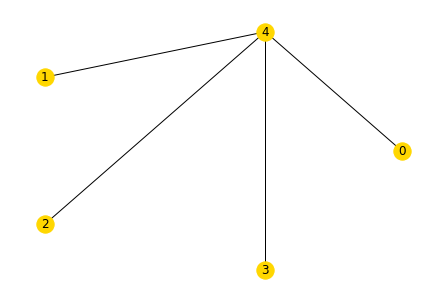

In [3]:
visible = [i for i in range(num_visible)]
hidden = [num_visible + j for j in range(num_hidden)]
edges = [(i, j) for i in visible for j in hidden]

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_circular(G, with_labels=True, node_color='gold')

In [4]:
from active_coresets.pamc_qbm import PAMC_QBM

2022-03-30 22:19:18.919709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 22:19:18.919748: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
import importlib
import active_coresets
importlib.reload(active_coresets.qmc_tim_qbm)
importlib.reload(active_coresets.pamc_qbm)
from active_coresets.pamc_qbm import PAMC_QBM

In [6]:
def mixed_bernoulli(N, q, dim):
    def dist(bits1, bits2):
        d = 0
        for i in range(len(bits1)):
            if bits1[i] != bits2[i]:
                d += 1
        return d

    data_range = np.zeros((2 ** dim, dim))
    for d in range(2**dim):
        binary = format(d, "b")
        for i, b in enumerate(binary[::-1]):
            data_range[d, dim-1-i] = int(b)
    
    modes = np.random.randint(0, 2, size=(N, dim))
    b_dist = {}
    for data in data_range:
        prob = 0.0
        for i in range(N):
            d = dist(data, modes[i])
            prob += np.power(q, d) * np.power(1 - q, dim - d)
        b_dist[tuple(data)] = prob / N
    return b_dist


In [7]:
def sample_dist(num_samples, dist):
    samples = []
    for s in range(num_samples):
        rand = np.random.rand()
        prob_total = 0.0
        for data, prob in dist.items():
            prob_total += prob
            if prob_total > rand:
                samples.append(data)
                break
    return np.array(samples)

In [8]:
b_dist = mixed_bernoulli(8, 0.9, num_visible)

In [22]:
num_samples = 1000
b_data = -2 * sample_dist(num_samples, b_dist) + np.ones((num_samples, num_visible))

In [23]:
pamc_qbm = PAMC_QBM(visible, hidden, gamma=2, population_size=512)
pop_history = pamc_qbm.train(b_data.astype(np.float32), epochs=10, batch_size=10, betas=np.linspace(0,10,5).astype(np.float32), num_its=10, learning_rate=0.01, exact=False, v_interval=20, debug=False)

Epoch 1
...Batch 20 / 100
...KL: (3.1803810831687938+0j)
...Batch 40 / 100
...KL: (3.3716381070008556+0j)
...Batch 60 / 100
...KL: (3.6909624965782433+0j)
...Batch 80 / 100
...KL: (4.007642536599894+0j)
...Batch 100 / 100
...KL: (4.315706003894206+0j)
Epoch 2
...Batch 20 / 100
...KL: (4.699640414582062+0j)
...Batch 40 / 100
...KL: (5.134168228048475+0j)
...Batch 60 / 100
...KL: (5.48926992004551+0j)
...Batch 80 / 100
...KL: (5.827968341378277+0j)
...Batch 100 / 100
...KL: (6.014628984862691+0j)
Epoch 3
...Batch 20 / 100
...KL: (6.283740383476345+0j)
...Batch 40 / 100
...KL: (6.5123836184414206+0j)
...Batch 60 / 100
...KL: (6.733981113868862+0j)
...Batch 80 / 100
...KL: (6.9894974373023695+0j)
...Batch 100 / 100
...KL: (7.12425480675237+0j)
Epoch 4
...Batch 20 / 100
...KL: (7.313225243626852+0j)
...Batch 40 / 100
...KL: (7.502022055535029+0j)
...Batch 60 / 100
...KL: (7.7171005447331416+0j)
...Batch 80 / 100
...KL: (7.958059171877374+0j)
...Batch 100 / 100
...KL: (8.111936048753776+0j)


In [24]:
def data_to_dict(data):
    dict = {}
    for z_pt in data:
        bitstring = ''.join(['0' if b == 1 else '1' for b in z_pt])
        pt = int(bitstring, 2)
        if pt in dict:
            dict[pt] += 1
        else:
            dict[pt] = 1
    return {k: v / sum(dict.values()) for k, v in dict.items()}

In [25]:
def y_range(dict, x_range):
    y = []
    for x in x_range:
        if x in dict:
            y.append(dict[x])
        else:
            y.append(0)
    return y

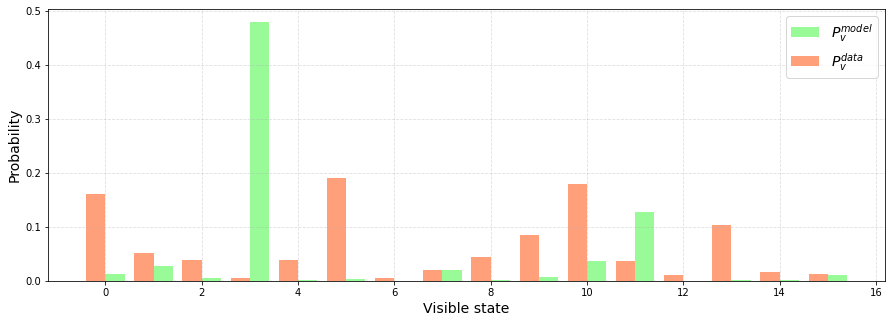

In [35]:
fig, ax = plt.subplots(figsize=[15,5])

x_range = range(2 ** len(visible))
data_dist = data_to_dict(b_data)
init_model_dist = data_to_dict(pop_history[3])
width = 0.4

m_bars = ax.bar(x_range, y_range(init_model_dist, x_range), color='palegreen', label=r'$P^{model}_v$', align='edge', width=width)
d_bars = ax.bar(x_range, y_range(data_dist, x_range), color='lightsalmon', label=r'$P^{data}_v$', align='edge', width=-width)

plt.grid(alpha=.4, linestyle='--')
plt.legend(fontsize=14)
plt.xlabel(r'Visible state', fontsize=14)
plt.ylabel('Probability', fontsize=14)

plt.show()

In [ ]:
# from matplotlib.animation import FuncAnimation
# %matplotlib widget

In [ ]:
# def update(frame):
#     #model_population = pop_history[frame]
#     #model_dict = data_to_dict(model_population[:, :len(visible)])
#     model_dict = pop_history[frame]
#     for rect, y in zip(m_bars, y_range(model_dict, x_range)):
#         rect.set_height(y)
#     plt.title(f"frame: {frame}")

# anim = FuncAnimation(fig, update, interval=50, frames=np.array(range(len(pop_history))))
# plt.show()